It's time to start the modeling process. But first let's import all the dependencies we would need and load up the data. 

In [43]:
# Neural network & imports
from keras.models import Sequential
from keras.layers import Dense 
import keras 

# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")
print ("tensorflow on Python 3.x and Windows 10 needed the latest MS Visual C++ lib installed")
print("https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads")

tensorflow on Python 3.x and Windows 10 needed the latest MS Visual C++ lib installed
https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads


In [13]:
# Import numpy
import numpy as np
import tensorflow as tf

# Fix the random seed
np.random.seed(7)
tf.random.set_seed(666)

In [14]:
# Load the numpy arrays which will be our datasets from now
X_train, y_train = np.load("X_train.npy", allow_pickle=True), np.load("y_train.npy", allow_pickle=True)
X_test, y_test = np.load("X_test.npy", allow_pickle=True), np.load("y_test.npy", allow_pickle=True)
print ("X_train", X_train.size)
print ("X_test", X_test.size)

X_train 265320
X_test 265320


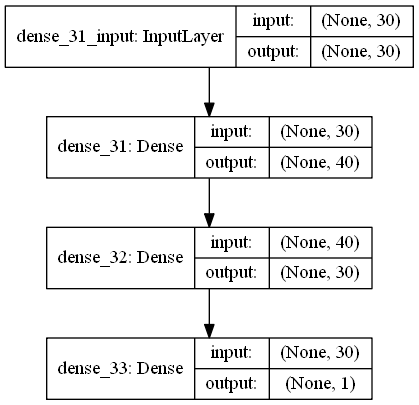

In [19]:
# define the keras model
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

from keras.utils import plot_model 

def get_training_model(cols):
    model = Sequential()
    model.add(Dense(40, activation="relu",kernel_initializer="uniform",input_dim=cols)) # modified from sayaks solution
    model.add(Dense(30, activation="relu",kernel_initializer="uniform"))
    model.add(Dense(1,  activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


model = get_training_model(X_train.shape[1])

# plot needed vc++ lib ,  pydot library ,  and Graphviz executable in PATH
keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)





In [30]:
# run all 128 epochs
import time 
start  = time.time() 
duration = time.time() - start
print(f'time to train: {duration}')
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=128, batch_size=64)
duration = time.time() - start
print(f'time to train: {duration}')
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

time to train: 0.0
Epoch 1/128
8844/8844 [==============================] - 0s 17us/step - loss: 0.0269 - accuracy: 0.9879
Epoch 2/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0279 - accuracy: 0.9870
Epoch 3/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0265 - accuracy: 0.9877
Epoch 4/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0259 - accuracy: 0.9865
Epoch 5/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0260 - accuracy: 0.9869
Epoch 6/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0277 - accuracy: 0.9855
Epoch 7/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0272 - accuracy: 0.9880
Epoch 8/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0266 - accuracy: 0.9874
Epoch 9/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0275 - accuracy: 0.9872
Epoch 10/128
8844/8844 [=====================

In [15]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_23 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 31        
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping
es_cb = EarlyStopping(monitor="loss", 
    patience=5, # number of epochs to consider
    restore_best_weights=True, # restore the best weights when loss stops enhancing
    verbose=1)

In [33]:
# try again with early stopping, skip the wandb for the moment
model = get_training_model(X_train.shape[1])
start  = time.time()  
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=128, batch_size=64,callbacks=[es_cb])
duration = time.time() - start
print(f'time to train with ABS early stopping: {duration}')
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/128
8844/8844 [==============================] - 0s 26us/step - loss: 0.3584 - accuracy: 0.8822
Epoch 2/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.1995 - accuracy: 0.9228
Epoch 3/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.1916 - accuracy: 0.9270
Epoch 4/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.1888 - accuracy: 0.9261
Epoch 5/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.1806 - accuracy: 0.9268
Epoch 6/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.1746 - accuracy: 0.9306
Epoch 7/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.1678 - accuracy: 0.9334
Epoch 8/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.1613 - accuracy: 0.9359
Epoch 9/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.1566 - accuracy: 0.9354
Epoch 10/128
8844/8844 [==============================] - 0s 15u

In [39]:
# using sayak's nifty little method
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
def train_network(model, name):
    # Initialize Weights and Biases
    wandb.init(project="phishing-websites-detection", name=name)
    
    start = time.time()
    history = model.fit(X_train, y_train, batch_size=64, epochs=128, verbose=1, \
        callbacks=[es_cb, WandbCallback()])
    end = time.time()-start
    prediction = model.predict_classes(X_test)
    wandb.log({"accuracy":accuracy_score(y_test, prediction)*100.0,\
               "precision": precision_recall_fscore_support(y_test, prediction, average="macro")[0],
               "recall": precision_recall_fscore_support(y_test, prediction, average="macro")[1],
               "training_time":end})
    print("Accuracy score of the Logistic Regression classifier with default hyperparameter values {0:.2f}%"\
                  .format(accuracy_score(y_test, prediction)*100.))
    print("\n")
    print("----Classification report of the Logistic Regression classifier with default hyperparameter value----")
    print("\n")
    print(classification_report(y_test, prediction, target_names=["Phishing Websites", "Normal Websites"]))

In [41]:
train_network(model, "neural-network")

Epoch 1/128
8844/8844 [==============================] - 0s 22us/step - loss: 0.0503 - accuracy: 0.9778
Epoch 2/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0452 - accuracy: 0.9810
Epoch 3/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0461 - accuracy: 0.9801
Epoch 4/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0440 - accuracy: 0.9812
Epoch 5/128
8844/8844 [==============================] - 0s 18us/step - loss: 0.0470 - accuracy: 0.9806
Epoch 6/128
8844/8844 [==============================] - 0s 17us/step - loss: 0.0457 - accuracy: 0.9798
Epoch 7/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0437 - accuracy: 0.9809
Epoch 8/128
8844/8844 [==============================] - 0s 16us/step - loss: 0.0427 - accuracy: 0.9818
Epoch 9/128
8844/8844 [==============================] - 0s 15us/step - loss: 0.0417 - accuracy: 0.9816
Epoch 10/128
8844/8844 [==============================] - 0s 15u